In [5]:
import numpy as np
import matplotlib.pyplot as plt

from normalizing_flow_utils import calc_dkl, calc_logMSE, calc_MSE, train_model

#!pip install github.com/rikab/rikabplotlib.git
from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline



In [2]:
# Physics Params
E0 = 500            # Energy of Hard Process
Lambda_QCD = 0.2    # Lambda QCD
cutoff = 0.01      # Cutoff for minimum lambda, ~ LambdaQCD / E0
R = 0.4             # Jet Radius

# Training Params
num_epochs = 2500
lr = .01
batch_size = 512
num_points = 10 # we define a prior on each point along the horizontal axis
                # eventually this should be made large

In [3]:
import torch

# TODO: Need to write a grad preserving numpy-to-torch converter for these functions

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2))


In [ ]:
# Loss functions
# 3 defaults in the normalizing_flow_utils module: calc_dkl, calc_logMSE, calc_MSE


def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x)

def calc_dkl(logp, logq):
    print("logp", logp)
    print("logq", logq)
    return torch.sum((logp - logq))

# def batch_MSE(logp, logq):


#     p = torch.exp(logp)
#     q = torch.exp(logq)

#     # We want p and q to agree up to O(counting_parameter^2)
#     error = 

#     return torch.mean((logp - logq)**2)

In [14]:

# TODO: Weird issue, have to run exactly once before it works the second time time
model, losses = train_model(LO_angularity, calc_dkl, 2500, num_points, batch_size, lr)

fig, ax = newplot("column")
ax.plot(losses, label="KL Loss", color = "black")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.yscale("log")

  1%|          | 22/2500 [00:01<02:53, 14.32it/s]


ValueError: Expected parameter loc (Parameter of shape (2,)) of distribution Normal(loc: torch.Size([2]), scale: torch.Size([2])) to satisfy the constraint Real(), but found invalid values:
Parameter containing:
tensor([nan, nan], requires_grad=True)

TORCH DEVICE: cpu
integral tensor(0.8215)
integral tensor(16.3400)


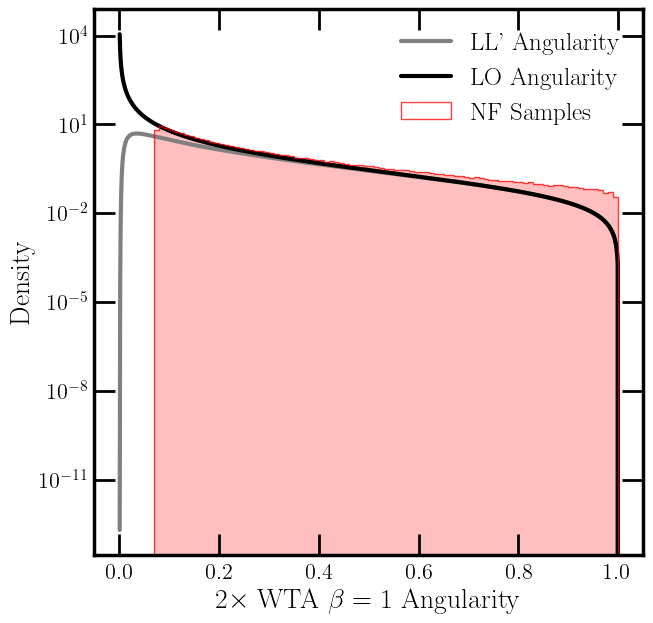

In [13]:
from normalizing_flow_utils import SimpleNormal, grab

if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
    print(f"TORCH DEVICE: {torch_device}")


# Plot details
fig, ax = newplot("full")
plt.yscale("log")
plt.xlabel(r"$2 \times $ WTA $\beta = 1$ Angularity")
plt.ylabel("Density")
samples = 1000


# Leading Log Angularity
x_test = torch.linspace(0.001, 1, samples)
y_test = LL_angularity(x_test)
print("integral", torch.trapz(y_test, x_test))
ax.plot(x_test, y_test, label="LL' Angularity", color = "grey")

# Leading Order Angularity
x_test = torch.linspace(0.001, 1, samples)
y_test = LO_angularity(x_test)
print("integral", torch.trapz(y_test, x_test))
ax.plot(x_test, y_test, label="LO Angularity", color = "black")

# Normalizing Flow -- samples
prior = SimpleNormal(torch.zeros(samples), torch.ones(samples))
z = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
x, logJ = model(z)
x = grab(x)
hist_with_outline(ax, x / np.max(x), bins=100, range=(0,1), label="NF Samples", color = "red", density = True)

# # Normalizing Flow -- density
# logq = prior.log_prob(z)
# logJ = logJ.reshape(batch_size, samples)
# logp = logq - logJ
# p = torch.exp(logp)
# p = grab(p)
# plt.plot(x, p.flatten(), label="NF Density", color = "red")

plt.legend(loc = 'upper right')

